# Ejercicio análisis time series
Para este ejercicio vas a trabajar con el histórico de valores en bolsa de una empresa que se dedica a vender muebles. Se pide
1. Importa los datos 'df_furniture.csv'
2. Trata la fecha como texto. Crea una columna para el año, mes y dia, y a partir de esas columnas crea la de fecha, en formato datetime de pandas
3. ¿De qué fecha a qué fecha va el histórico?
4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?
5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?
6. Parece que hay una tendencia, pero no se aprecia bien con tanto pico en la serie. ¿Conoces algún método para representar mejor la tendencia?
7. Estaría bien visualizar todos los componentes de la serie temporal por separado
8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional
9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuéstralo mediante una matriz de correlación. ¿Esto es bueno para los modelos?
10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?
11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

In [73]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [74]:
#!pip install numpy==1.23.5
#!pip install Cython
#!pip install pmdarima

## 1. Cargamos los datos

In [75]:
df = pd.read_csv('data/df_furniture.csv', parse_dates = ['Month'])
df.head()

,Month,furniture_price_adjusted
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Month                     326 non-null    datetime64[ns]
 1   furniture_price_adjusted  331 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 KB


In [77]:
df.describe()

,Month,furniture_price_adjusted
count,326,331.000000
mean,2005-11-30 13:23:55.582822144,5975.765787
min,1992-01-01 00:00:00,2073.432724
25%,1999-03-08 18:00:00,4280.088499
50%,2005-12-16 12:00:00,6075.405272
75%,2012-09-23 12:00:00,7381.403461
max,2019-07-01 00:00:00,10833.501852
std,NaN,2092.867819


In [78]:
df.head()

,Month,furniture_price_adjusted
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


## 2. Tratar la fecha como texto y parsear

In [79]:
# Realizado en paso anteriror

## 3. ¿De qué fecha a qué fecha va el histórico?

In [80]:
start_date = df['Month'].min()
end_date = df['Month'].max()
print(f"El histórico va desde {start_date} hasta {end_date}")


El histórico va desde 1992-01-01 00:00:00 hasta 2019-07-01 00:00:00


## 4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?

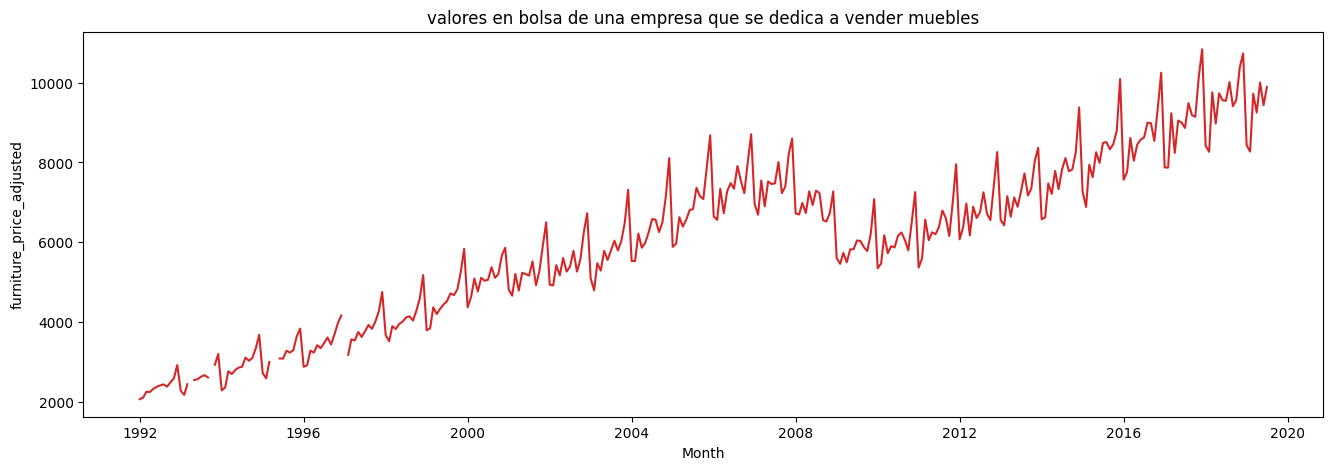

In [90]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Month', ylabel='furniture_price_adjusted', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.Month, y=df.furniture_price_adjusted, title='valores en bolsa de una empresa que se dedica a vender muebles') 


In [ ]:
# Import Data
df = pd.read_csv('data/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

## 5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?

In [92]:
from statsmodels.tsa.stattools import adfuller, kpss


result = adfuller(df['valores en bolsa de una empresa que se dedica a vender muebles'].values)
result[1]

KeyError: 'valores en bolsa de una empresa que se dedica a vender muebles'

## 6. ¿Conoces algún método para representar mejor la tendencia?

## 7. Estaría bien visualizar todos los componentes de la serie temporal por separado

## 8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional

## 9. ¿Qué dependencia tiene cada instante de sus últimos 5 lags? Demuéstralo mediante una matriz de correlación.

## 10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

## 11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?